# Transitioning to autonomous driving: <br>Mixed vehicle autonomy levels on freeways
### Notebook to analyse simulation warm-up time.

Jesse Poland<br>
TU Delft<br>
Date: 02-10-2024<br>

### 0. Python packages and loading data files

First, Python packages are imported to provide specific functionalities within the notebook. Then, the file paths are set to retrieve stored simulation data for all experiment runs and seeds. The simulation data is loaded into Pandas DataFrames, making the data ready for analysis.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from IPython.display import display
import zipfile
from collections import defaultdict

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_rows', None)

In [2]:
# simulation output folder
experiment_name = 'test_policy_run_1'

# load Java simulation data
# experiment_folder = fr'F:\jesse_sim_results\{experiment_name}'
experiment_folder = fr'..\data\{experiment_name}'

# available files
input_values = 'inputValues.csv'
intermediate_output = 'intermediateOutputData.csv'
single_output = 'singleOutputData.csv'
sequence_output = 'sequenceOutputData.csv'
lane_change_output = 'laneChangeOutputData.csv'
collision_output = 'collisionOutputData.csv'

In [3]:
# function to get a list of all file/folder names within a folder
def get_file_names(path):
    return os.listdir(path)

# load available seed folders
seed_folders = get_file_names(experiment_folder)

In [4]:
# function to retrieve any data within the project folder as dataframe
def load_scenario_dataframe(scenario, columns_of_interest, folder, file, input_file):
    # create empty DataFrame
    df = pd.DataFrame()
    
    # loop through all seed folders from this experiment
    for seed_name in get_file_names(folder):
        #############
        # stop at seed 2
        if seed_name == 'seed_2':
            break
        ###############
        
        # get all runs within this experiment
        run_folders = get_file_names(os.path.join(folder, seed_name))

        # go through all runs
        for run_folder in run_folders:
            run_number = int(run_folder.split('_')[1])
            data_folder = os.path.join(folder, seed_name, run_folder)

            # initialise scenario boolean
            row_matches_scenario = False

            # open zip file (remove .csv form file name)
            # check whether input file matches this scenario
            # open input zip file
            with zipfile.ZipFile(os.path.join(data_folder, fr'{input_file[:-4]}.zip'), 'r') as zip_ref:
                # read input csv
                with zip_ref.open(input_file) as input_data_file:
                    df_input = pd.read_csv(input_data_file)
                    row_matches_scenario = all(df_input.iloc[0][key] == value for key, value in scenario.items())
                    
            # get data if input values match this scenario
            if row_matches_scenario:
                with zipfile.ZipFile(os.path.join(data_folder, fr'{file[:-4]}.zip'), 'r') as zip_ref:
                    # read data csv
                    with zip_ref.open(file) as data_file:
                        df_run = pd.read_csv(data_file)
                        df_interest = df_run[columns_of_interest].copy()
                        df_interest['run'] = run_number

                        # broadcast input data to all rows in df_interest
                        for col in df_input.columns:
                            df_interest[col] = df_input[col].iloc[0]
                    
                        # add this data to the main DataFrame
                        df = pd.concat([df, df_interest])
    
    # return resulting DataFrame
    df.reset_index(drop=True, inplace=True)
    return df


# function to retrieve any data within the project folder as dataframe
def load_scenario_collision_dataframe(scenario, folder):
    # collision file
    file = collision_output
    input_file = input_values
    
    # create empty DataFrame
    df = pd.DataFrame()
    
    # loop through all seed folders from this experiment
    for seed_name in get_file_names(folder):
        
        # get all runs within this experiment
        run_folders = get_file_names(os.path.join(folder, seed_name))

        # go through all runs
        for run_folder in run_folders:
            run_number = int(run_folder.split('_')[1])
            data_folder = os.path.join(folder, seed_name, run_folder)

            # initialise scenario boolean
            row_matches_scenario = False

            # open zip file (remove .csv form file name)
            # check whether input file matches this scenario
            # open input zip file
            with zipfile.ZipFile(os.path.join(data_folder, fr'{input_file[:-4]}.zip'), 'r') as zip_ref:
                # read input csv
                with zip_ref.open(input_file) as input_data_file:
                    df_input = pd.read_csv(input_data_file)
                    row_matches_scenario = all(df_input.iloc[0][key] == value for key, value in scenario.items())
                    
            # get data if input values match this scenario
            if row_matches_scenario:
                with zipfile.ZipFile(os.path.join(data_folder, fr'{file[:-4]}.zip'), 'r') as zip_ref:
                    # read data csv
                    with zip_ref.open(file) as data_file:
                        # try to read collision data (will fail when empty)
                        try:
                            df_collisions = pd.read_csv(data_file)
                        # do not process empty collision dataframes
                        except:
                            continue
                        # do process collision  dataframe if it has data
                        print(f'Collisions found in {seed_name}-{run_number}')
                        df_collisions['run'] = run_number

                        # broadcast input data to all rows of collision dataframe
                        for col in df_input.columns:
                            df_collisions[col] = df_input[col].iloc[0]
                    
                        # add this data to the main DataFrame
                        df = pd.concat([df, df_collisions])
    
    # return resulting DataFrame
    df.reset_index(drop=True, inplace=True)
    return df

In [5]:
# define scenario 0
scenario_0 = {
    'level0_fraction': 1.0,
    'level1_fraction': 0.0,
    'level2_fraction': 0.0,
    'level3_fraction': 0.0,
    'in_vehicle_distraction': True,
    'road_side_distraction': False
}
scenario_1 = {
    'level0_fraction': 0.0,
    'level1_fraction': 1.0,
    'level2_fraction': 0.0,
    'level3_fraction': 0.0,
    'in_vehicle_distraction': True,
    'road_side_distraction': False
}
scenario_2 = {
    'level0_fraction': 0.0,
    'level1_fraction': 0.0,
    'level2_fraction': 1.0,
    'level3_fraction': 0.0,
    'in_vehicle_distraction': True,
    'road_side_distraction': False
}
scenario_3 = {
    'level0_fraction': 0.0,
    'level1_fraction': 0.0,
    'level2_fraction': 0.0,
    'level3_fraction': 1.0,
    'in_vehicle_distraction': True,
    'road_side_distraction': False
}

# function to filter a dataframe based on the scenario input values
def filter_dataframe_on_scenario(df, scenario):
    df_filtered = df[
        (df['level0_fraction'] == scenario['level0_fraction']) &
        (df['level1_fraction'] == scenario['level1_fraction']) &
        (df['level2_fraction'] == scenario['level2_fraction']) &
        (df['level3_fraction'] == scenario['level3_fraction']) &
        (df['in_vehicle_distraction'] == scenario['in_vehicle_distraction']) &
        (df['road_side_distraction'] == scenario['road_side_distraction'])
    ]
    return df_filtered

### Speed

In [6]:
# speed frequency per vehicle type
def show_speed_frequency(data_list, labels):
    # define colors for each DataFrame
    colors = ['steelblue', 'darkorange', 'yellow', 'green']

    # bin width
    bin_width=10

    # define speed bins
    max_speed = max(df['speed'].max() for df in data_list)
    bins = np.arange(0, max_speed + bin_width, bin_width)
    
    # create figure
    plt.figure(figsize=(8, 6))

    # width of each individual bar
    bar_width = bin_width * 0.08 / len(data_list)
    num_dfs = len(data_list)
    
    # loop through provided DataFrames
    for i, df in enumerate(data_list):
        # calculate frequency and normalize it
        speed_bin_counts = pd.cut(df['speed'], bins=bins).value_counts().sort_index()
        speed_bin_distribution = speed_bin_counts / len(df)
        
        # shift bars horizontally for each vehicle type
        x_positions = np.arange(len(bins) - 1) + i * bar_width - (num_dfs * bar_width) / 2

        # plot each bar
        plt.bar(x_positions, speed_bin_distribution, width=bar_width, color=colors[i % len(colors)], label=labels[i])
    
    # set x-axis labels as bin ranges
    bin_labels = [f'{int(bins[j])}-{int(bins[j+1])}' for j in range(len(bins) - 1)]
    plt.xticks(np.arange(len(bins) - 1), bin_labels, rotation=45)

    # show plot
    plt.xlabel('Speed (km/h)', fontsize=11)
    plt.ylabel('Frequency', fontsize=11)
    plt.title('Speed distribution per automation level', fontsize=14)
    plt.legend(title='Automation level', fontsize=11)
    plt.tight_layout()
    plt.show()

In [7]:
# get speed data scenario 0
speed_variables = ['time', 'speed', 'x_position', 'link', 'lane']
df_gtu_speed_0 = load_scenario_dataframe(scenario_0, speed_variables, experiment_folder, sequence_output, input_values)
# convert speed to km/h
df_gtu_speed_0['speed'] = df_gtu_speed_0['speed'] * 3.6

# get speed data scenario 1
df_gtu_speed_1 = load_scenario_dataframe(scenario_1, speed_variables, experiment_folder, sequence_output, input_values)
# convert speed to km/h
df_gtu_speed_1['speed'] = df_gtu_speed_1['speed'] * 3.6

# # get speed data scenario 2
# speed_variables = ['time', 'speed', 'x_position', 'link', 'lane']
# df_gtu_speed_2 = load_scenario_dataframe(scenario_2, speed_variables, experiment_folder, sequence_output, input_values)
# # convert speed to km/h
# df_gtu_speed_2['speed'] = df_gtu_speed_2['speed'] * 3.6

# # get speed data scenario 3
# df_gtu_speed_3 = load_scenario_dataframe(scenario_3, speed_variables, experiment_folder, sequence_output, input_values)
# # convert speed to km/h
# df_gtu_speed_3['speed'] = df_gtu_speed_3['speed'] * 3.6

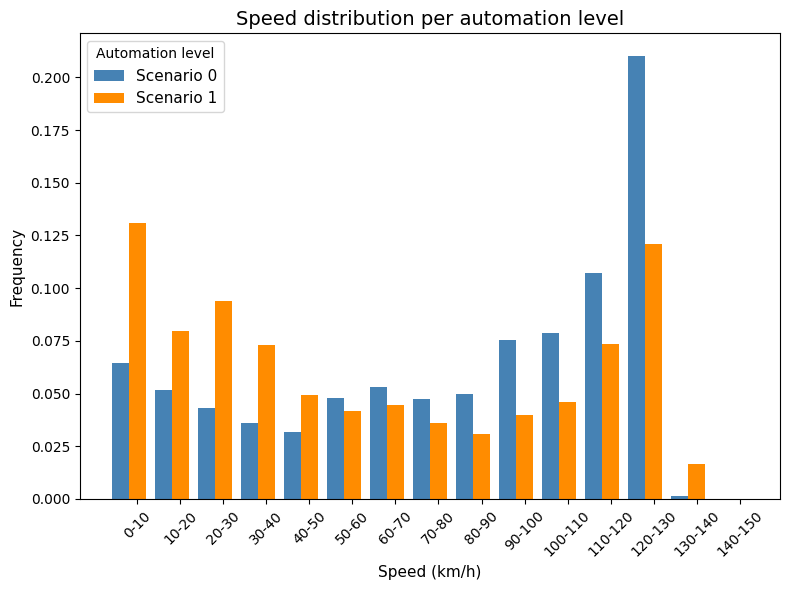

In [8]:
show_speed_frequency([df_gtu_speed_0, df_gtu_speed_1], ['Scenario 0', 'Scenario 1'])

In [9]:
# mean speed per vehicle type
def show_speed_boxplot(data_list, labels):
    # Collect the speed data for each vehicle type
    speed_data = [df['speed'] for df in data_list]
    
    # Create the box plot
    plt.figure(figsize=(10, 6))
    plt.boxplot(speed_data, labels=labels, patch_artist=True, showmeans=True)
    
    # Customize the plot
    plt.xlabel('Vehicle Type')
    plt.ylabel('Speed (km/h)')
    plt.title('Mean Speed Distribution per Vehicle Type')
    
    # Show the plot
    plt.grid(axis='y')
    plt.show()

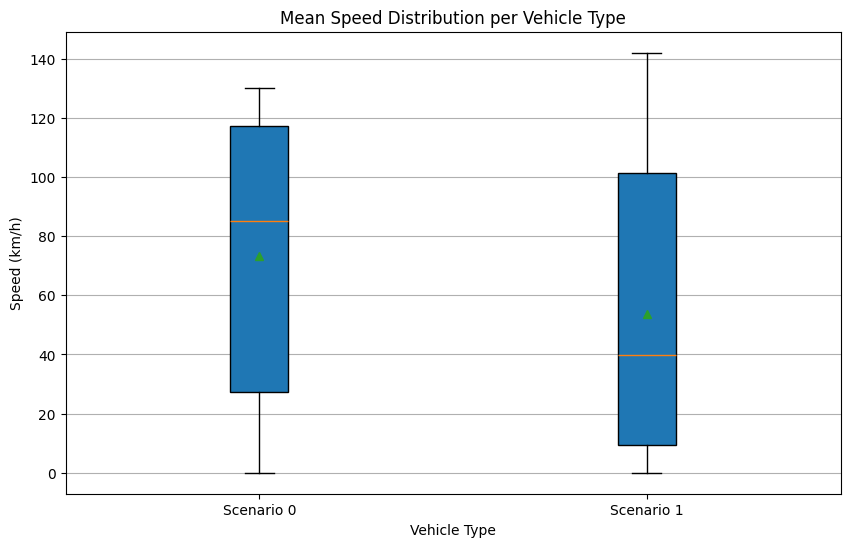

In [10]:
show_speed_boxplot([df_gtu_speed_0, df_gtu_speed_1], ['Scenario 0', 'Scenario 1'])

### Acceleration

In [11]:
def calculate_jerk(df):
    # define the time step in seconds
    time_step = 0.5
        
    # sort by time within each group to ensure jerk is calculated correctly
    df = df.sort_values(by=['gtu_id', 'seed', 'run', 'time'])
    
    # calculate jerk within each (gtu_id, seed, run) group
    df['jerk'] = (df.groupby(['seed', 'run', 'gtu_id'])['acceleration'].diff() / time_step )

    df = df.dropna(subset=['jerk'])
    return df


def show_acc_boxplot(df_list):
    # Create figure with two subplots for with/without outliers
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Define colors for each vehicle type
    colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightgray', 'lightyellow']

    for i, show_outliers in enumerate([True, False]):
        # Initialize data storage for jerk by vehicle type
        jerk_data = {}

        # Loop through vehicle type dataframes
        for df_type in df_list:
            # Sort by time within each group to ensure jerk is calculated correctly
            df = df_type.sort_values(by=['gtu_id', 'seed', 'run', 'time'])

            # Get vehicle type for legend
            vehicle_type = df['gtu_type'].iloc[0] if not df['gtu_type'].isna().all() else "Unknown"

            # Store jerk values by vehicle type
            if vehicle_type in jerk_data:
                jerk_data[vehicle_type].extend(df['acceleration'].tolist())
            else:
                jerk_data[vehicle_type] = df['acceleration'].tolist()

        # Create the box plot with or without outliers based on `show_outliers`
        box = axes[i].boxplot(
            jerk_data.values(), labels=jerk_data.keys(),
            showfliers=show_outliers, showmeans=True, patch_artist=True
        )
        
        # Apply colors to the boxes
        for patch, color in zip(box['boxes'], colors):
            patch.set(facecolor=color)

        # set plot title and labels
        title_suffix = 'with outliers' if show_outliers else 'without outliers'
        axes[i].set_title(f"Boxplot for acceleration per vehicle type ({title_suffix})", fontsize=14)
        axes[i].set_xlabel('Vehicle type', fontsize=11)
        axes[i].set_ylabel('Acceleration (m/s2)', fontsize=11)
        axes[i].tick_params(axis='x', rotation=0)

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()


def show_jerk_boxplot(df_list):
    # Create figure with two subplots for with/without outliers
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Define colors for each vehicle type
    colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightgray', 'lightyellow']

    for i, show_outliers in enumerate([True, False]):
        # Initialize data storage for jerk by vehicle type
        jerk_data = {}

        # Loop through vehicle type dataframes
        for df_type in df_list:
            # Sort by time within each group to ensure jerk is calculated correctly
            df = df_type.sort_values(by=['gtu_id', 'seed', 'run', 'time'])

            # Get vehicle type for legend
            vehicle_type = df['gtu_type'].iloc[0] if not df['gtu_type'].isna().all() else "Unknown"

            # Store jerk values by vehicle type
            if vehicle_type in jerk_data:
                jerk_data[vehicle_type].extend(df['jerk'].tolist())
            else:
                jerk_data[vehicle_type] = df['jerk'].tolist()

        # Create the box plot with or without outliers based on `show_outliers`
        box = axes[i].boxplot(
            jerk_data.values(), labels=jerk_data.keys(),
            showfliers=show_outliers, showmeans=True, patch_artist=True
        )
        
        # Apply colors to the boxes
        for patch, color in zip(box['boxes'], colors):
            patch.set(facecolor=color)

        # set plot title and labels
        title_suffix = 'with outliers' if show_outliers else 'without outliers'
        axes[i].set_title(f"Boxplot for rate of change of acceleration per vehicle type ({title_suffix})", fontsize=12)
        axes[i].set_xlabel('Vehicle type', fontsize=11)
        axes[i].set_ylabel('Rate of change of acceleration (m/s3)', fontsize=11)
        axes[i].tick_params(axis='x', rotation=0)

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()
    

In [12]:
# load GTU data for acceleration
acc_variables = ['time', 'gtu_id', 'gtu_type', 'speed', 'acceleration', 'headway_time', 'leader_gtu_id', 'leader_gtu_type']
df_gtu_acc_0 = load_scenario_dataframe(scenario_0, acc_variables, experiment_folder, sequence_output, input_values)
df_gtu_acc_1 = load_scenario_dataframe(scenario_1, acc_variables, experiment_folder, sequence_output, input_values)
# df_gtu_acc_2 = load_scenario_dataframe(scenario_2, acc_variables, experiment_folder, sequence_output, input_values)
# df_gtu_acc_3 = load_scenario_dataframe(scenario_3, acc_variables, experiment_folder, sequence_output, input_values)

# calculate jerk
df_gtu_acc_0 = calculate_jerk(df_gtu_acc_0)
df_gtu_acc_1 = calculate_jerk(df_gtu_acc_1)

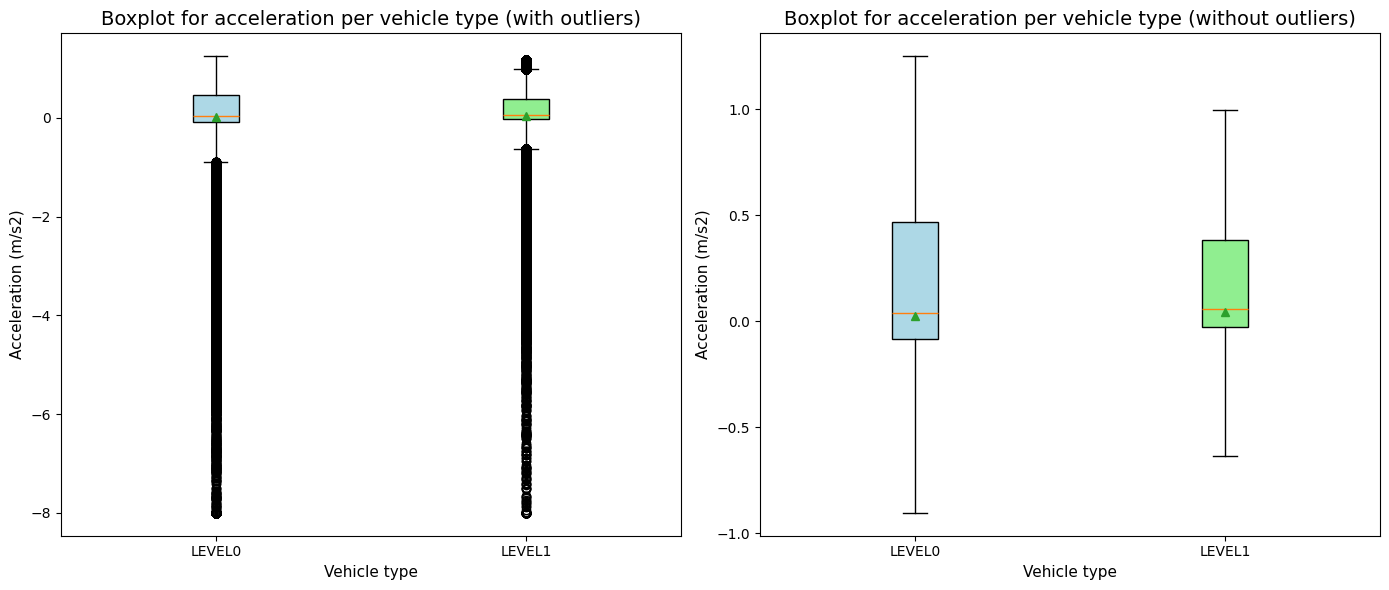

In [13]:
# show acceleration
show_acc_boxplot([df_gtu_acc_0, df_gtu_acc_1])

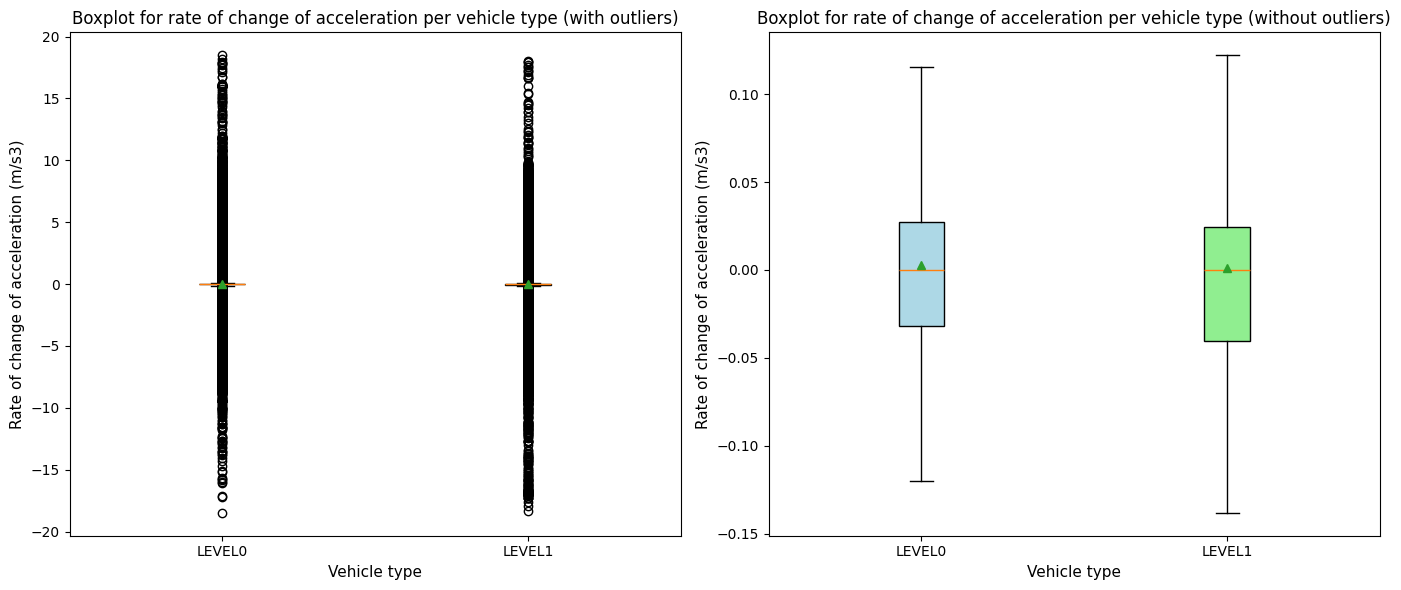

In [14]:
# show jerk
show_jerk_boxplot([df_gtu_acc_0, df_gtu_acc_1])
# show_jerk_boxplot([df_gtu_acc_0, df_gtu_acc_1, df_gtu_acc_2, df_gtu_acc_3])

### Headway analysis

In [15]:
# min, mean, max headway for time and distance
def show_headway_time_boxplot(df_list, labels):
    # get headway time data for each vehicle type
    headway_data = [df['headway_time'][(df['headway_time'] < 4) & (df['headway_time'] > 0.05)].dropna().tolist() for df in df_list]

    # create plot
    plt.figure(figsize=(10, 6))
    box = plt.boxplot(headway_data, labels=labels, showfliers=True, showmeans=True, patch_artist=True)

    # set colors
    colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightgray', 'lightyellow']
    for patch, color in zip(box['boxes'], colors):
        patch.set(facecolor=color)

    # show plot
    plt.title("Boxplot for headway time per automation level")
    plt.xlabel("Vehicle Type")
    plt.ylabel("Headway time (s)")
    plt.xticks(rotation=45)
    plt.show()

In [16]:
# collect headway data
headway_variables = ['time', 'gtu_id', 'gtu_type', 'x_position', 'headway_time', 'headway_distance', 'leader_gtu_id', 'leader_gtu_type', 'lane', 'link']
df_gtu_headway_0 = load_scenario_dataframe(scenario_0, headway_variables, experiment_folder, sequence_output, input_values)
df_gtu_headway_1 = load_scenario_dataframe(scenario_1, headway_variables, experiment_folder, sequence_output, input_values)
# df_gtu_headway_2 = load_scenario_dataframe(scenario_2, headway_variables, experiment_folder, sequence_output, input_values)
# df_gtu_headway_3 = load_scenario_dataframe(scenario_3, headway_variables, experiment_folder, sequence_output, input_values)

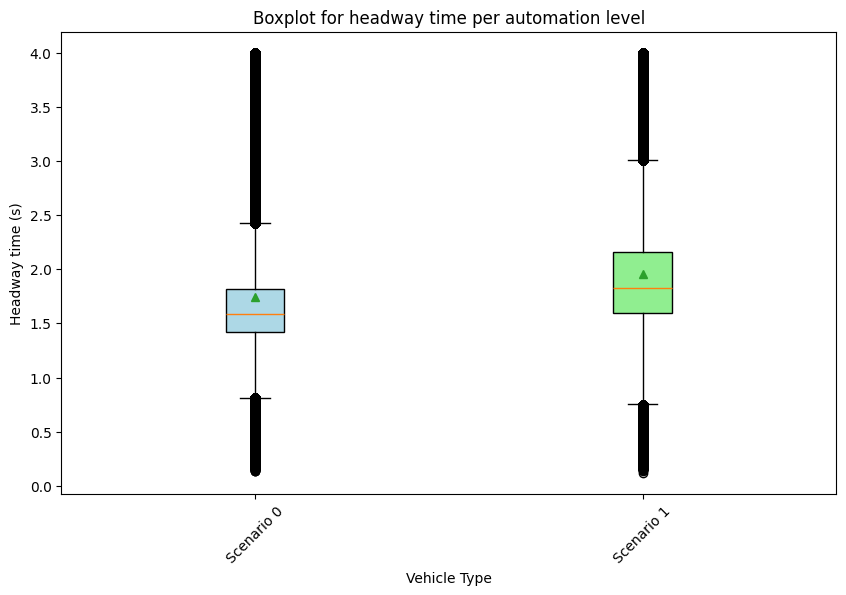

In [17]:
# show boxplots
show_headway_time_boxplot([df_gtu_headway_0, df_gtu_headway_1], ['Scenario 0', 'Scenario 1'])

### Switches in leader vehicles

In [18]:
# choose 100 random vehicles per level and count their lane switches

# calculate lane switches / h

# corresponds to headway analysis?

In [19]:
def count_leader_switches(df, sample_size=100):
    # Initialize list to store switch counts along with vehicle information
    switch_counts = []
    
    # Group by each (run, seed, gtu_type) combination
    for (run, seed, gtu_type), group in df.groupby(['run', 'seed', 'gtu_type']):
        # Sample 100 unique GTUs within this (run, seed, gtu_type) group
        sampled_gtus = group['gtu_id'].drop_duplicates().sample(n=min(sample_size, len(group['gtu_id'].unique())), random_state=1)
        
        # Filter the group to include only sampled GTUs
        group_sampled = group[group['gtu_id'].isin(sampled_gtus)]
        
        # Sort by gtu_id and time to ensure correct order for each sampled GTU
        group_sampled = group_sampled.sort_values(by=['gtu_id', 'time'])
        
        # Count leader switches for each sampled GTU in this (run, seed, gtu_type) group
        for gtu_id, gtu_group in group_sampled.groupby('gtu_id'):
            # Create a shifted column to check if leader_gtu_id changes from one row to the next
            gtu_group = gtu_group.reset_index(drop=True)
            gtu_group['leader_change'] = gtu_group['leader_gtu_id'].ne(gtu_group['leader_gtu_id'].shift())
            
            # The count of switches is the sum of True values in 'leader_change' (minus the first row)
            switch_count = gtu_group['leader_change'].sum() - 1  # Subtract 1 to exclude the initial leader assignment

            # calculate travel time
            travel_time = gtu_group['time'].iloc[-1] - gtu_group['time'].iloc[0]
            
            # Store the switch count along with vehicle information
            switch_counts.append({
                'gtu_id': gtu_id,
                'seed': seed,
                'run': run,
                'gtu_type': gtu_type,
                'leader_switch_count': switch_count,
                'travel_time': travel_time
            })
    
    # Convert switch counts to DataFrame
    switch_counts_df = pd.DataFrame(switch_counts)
    
    return switch_counts_df

def plot_leader_switches_per_hour(data_list):
    colors = ['skyblue', 'lightgreen', 'salmon', 'orange', 'purple']
    
    # Concatenate all DataFrames in data_list
    combined_df = pd.concat(data_list, ignore_index=True)
    
    # Calculate switches per hour for each vehicle
    combined_df['switches_per_hour'] = (combined_df['leader_switch_count'] / combined_df['travel_time']) * 3600

    # Calculate the mean switches per hour for each vehicle type
    mean_switches_per_hour = combined_df.groupby('gtu_type')['switches_per_hour'].mean()
    
    # Create a bar plot for the mean leader switch count per vehicle type
    plt.figure(figsize=(8, 6))
    mean_switches_per_hour.plot(kind='bar', width=0.5, color=colors[:len(mean_switches_per_hour)])
    
    # Customize the plot
    plt.title('Mean number of leader switches per vehicle type', fontsize=14)
    plt.xlabel('Vehicle type', fontsize=11)
    plt.ylabel('Mean leader switches per hour', fontsize=11)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

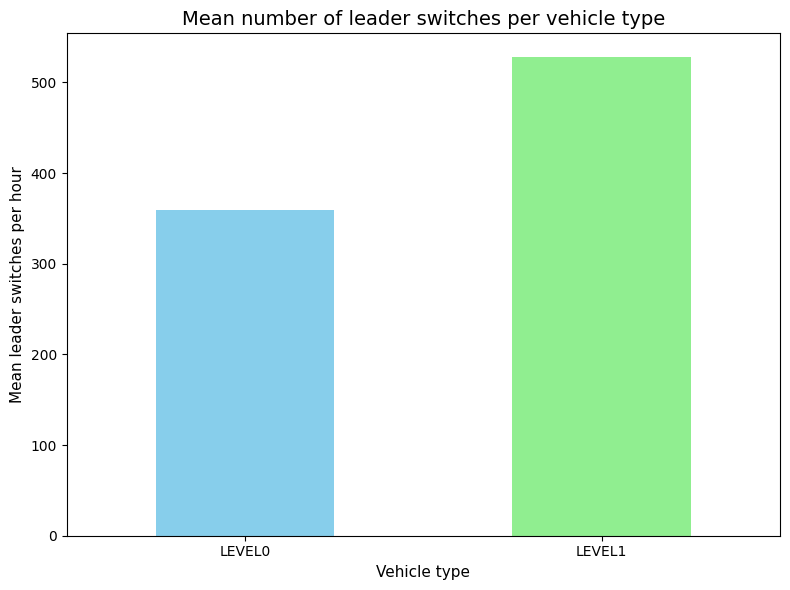

In [20]:
df_switch_count_0 = count_leader_switches(df_gtu_headway_0, sample_size=200)
df_switch_count_1 = count_leader_switches(df_gtu_headway_1, sample_size=200)

plot_leader_switches_per_hour([df_switch_count_0, df_switch_count_1])

### Vehicle string length

In [21]:
# data per lane
# for each time step, sort on x_position and access headway distance
# > x meters is a gap -> breaks string
# count string lengths
def determine_vehicle_string_lengths(data_list, labels, gap_threshold=10):
    # Dictionary to store string lengths by scenario and lane
    string_lengths = {label: {'LEFT': [], 'RIGHT': []} for label in labels}
    
    # Loop through each DataFrame in the data list
    for df_scen, label in zip(data_list, labels):
        # Only include main lanes
        main_lanes = ['LEFT', 'RIGHT']
        df = df_scen[df_scen['lane'].isin(main_lanes)].copy()
        
        # Group by each lane and time step to analyze vehicle positions within each lane at each time slice
        for (time, lane), time_lane_group in df.groupby(['time', 'lane']):
            # Sort vehicles by x_position within each (time, lane) group
            time_lane_group = time_lane_group.sort_values('x_position').reset_index(drop=True)
            
            # Calculate gaps between consecutive vehicles
            gaps = time_lane_group['x_position'].diff().fillna(0)
            
            # Find indexes where gaps exceed the threshold
            gap_indexes = gaps[gaps > gap_threshold].index
            
            # Calculate string lengths by subtracting gap indexes
            start_idx = 0
            current_string_lengths = []
            for gap_idx in gap_indexes:
                # Calculate length of string (number of vehicles) between gaps
                string_length = gap_idx - start_idx
                if string_length > 0:
                    current_string_lengths.append(string_length)
                start_idx = gap_idx  # Reset start index to the current gap
            
            # Include the final string after the last gap
            final_string_length = len(time_lane_group) - start_idx
            if final_string_length > 0:
                current_string_lengths.append(final_string_length)
            
            # Store string lengths for this lane and time in the current scenario
            if current_string_lengths:
                string_lengths[label][lane].extend(current_string_lengths)
    
    # Calculate mean string length per lane and scenario, then store in DataFrame
    mean_string_lengths = []
    for label in labels:
        for lane in main_lanes:
            # Calculate mean string length for this lane and scenario
            mean_length = sum(string_lengths[label][lane]) / len(string_lengths[label][lane]) if string_lengths[label][lane] else 0
            mean_string_lengths.append({'Scenario': label, 'Lane': lane, 'Mean_String_Length': mean_length})
    
    # Convert to DataFrame for easy analysis and plotting
    mean_string_lengths_df = pd.DataFrame(mean_string_lengths)
    
    return mean_string_lengths_df

In [22]:
df_mean_string_length = determine_vehicle_string_lengths([df_gtu_headway_0, df_gtu_headway_1], ['Scenario 0', 'Scenario 1'], gap_threshold=10)

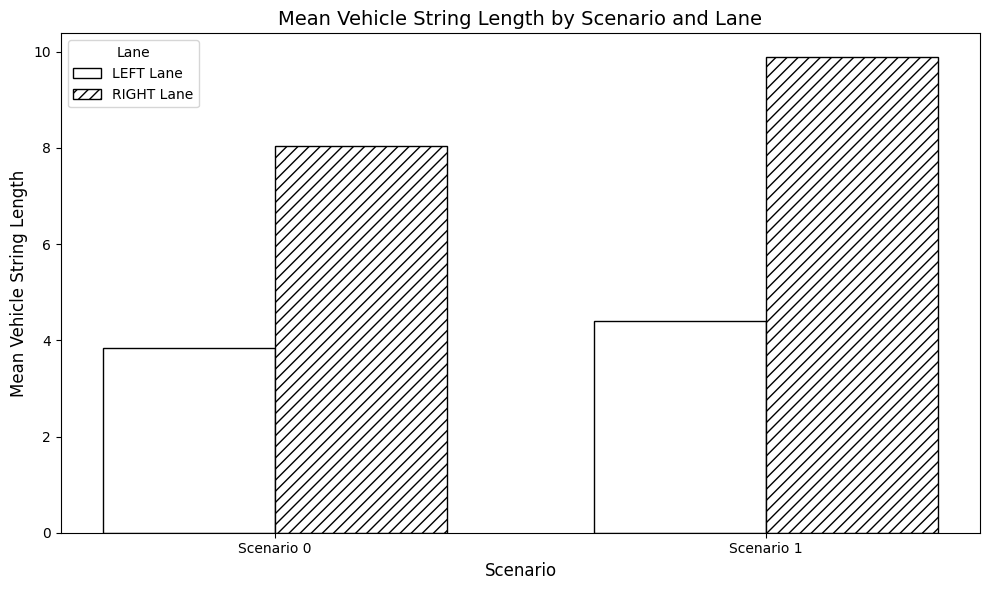

In [23]:
def plot_vehicle_string_lengths(mean_string_lengths_df):
    # Colors and hatch patterns for lanes
    facecolor = 'white'
    hatches = [None, '///']  # No hatch for LEFT lane, hatch for RIGHT lane
    
    # Extract unique scenarios and lanes
    scenarios = mean_string_lengths_df['Scenario'].unique()
    lanes = mean_string_lengths_df['Lane'].unique()
    
    # Set up the bar width and positions
    bar_width = 0.35
    x = np.arange(len(scenarios))  # Label locations for each scenario

    # Create the figure
    plt.figure(figsize=(10, 6))
    
    # Plot each lane's mean string length as separate bars for each scenario
    for i, lane in enumerate(lanes):
        lane_data = mean_string_lengths_df[mean_string_lengths_df['Lane'] == lane]
        plt.bar(
            x + i * bar_width,
            lane_data['Mean_String_Length'],
            width=bar_width,
            color=facecolor,
            edgecolor='black',  # Outline to make the bars visible
            hatch=hatches[i],
            label=f'{lane} Lane'
        )
    
    # Add labels and title
    plt.xlabel('Scenario', fontsize=12)
    plt.ylabel('Mean Vehicle String Length', fontsize=12)
    plt.title('Mean Vehicle String Length by Scenario and Lane', fontsize=14)
    
    # Add scenario labels in the middle of each group of bars
    plt.xticks(x + bar_width / 2, scenarios, rotation=0)
    
    # Add legend
    plt.legend(title='Lane')
    
    # Show the plot
    plt.tight_layout()
    plt.show()

plot_vehicle_string_lengths(df_mean_string_length)

### Lane-chaning behaviour

In [24]:
def add_follower_headway_info(df):
    # Create a MultiIndex Series for fast lookup of headway values by follower GTU
    headway_time_map = df.set_index(['gtu_id', 'seed', 'run', 'time'])['headway_time']
    headway_distance_map = df.set_index(['gtu_id', 'seed', 'run', 'time'])['headway_distance']
    gtu_type_map = df.set_index(['gtu_id', 'seed', 'run', 'time'])['gtu_type']
    
    # Use 'map' to fill in the follower headway columns by matching the follower_gtu_id, seed, run, and time
    df['follower_headway_time'] = df.set_index(['follower_gtu_id', 'seed', 'run', 'time']).index.map(headway_time_map)
    df['follower_headway_distance'] = df.set_index(['follower_gtu_id', 'seed', 'run', 'time']).index.map(headway_distance_map)
    df['follower_gtu_type'] = df.set_index(['follower_gtu_id', 'seed', 'run', 'time']).index.map(gtu_type_map)

    return df

In [25]:
# get GTU data for lane-changing
gtu_lc_variables = ['time', 'gtu_id', 'gtu_type', 'speed', 'headway_time', 'headway_distance', 'leader_gtu_id', 'leader_gtu_type', 'follower_gtu_id', 'turn_indicator', 'link', 'lane']
df_gtu_lc_0 = load_scenario_dataframe(scenario_0, gtu_lc_variables, experiment_folder, sequence_output, input_values)
df_gtu_lc_1 = load_scenario_dataframe(scenario_1, gtu_lc_variables, experiment_folder, sequence_output, input_values)
# filter input parameters
df_gtu_lc_0 = df_gtu_lc_0[['seed', 'run'] + gtu_lc_variables]
df_gtu_lc_1 = df_gtu_lc_1[['seed', 'run'] + gtu_lc_variables]
# add follower data
df_gtu_lc_0 = add_follower_headway_info(df_gtu_lc_0)
df_gtu_lc_1 = add_follower_headway_info(df_gtu_lc_1)

In [26]:
print(df_gtu_lc_0.columns.tolist())

['seed', 'run', 'time', 'gtu_id', 'gtu_type', 'speed', 'headway_time', 'headway_distance', 'leader_gtu_id', 'leader_gtu_type', 'follower_gtu_id', 'turn_indicator', 'link', 'lane', 'follower_headway_time', 'follower_headway_distance', 'follower_gtu_type']


In [27]:
df_gtu_lc_0.head()

,seed,run,time,gtu_id,gtu_type,speed,headway_time,headway_distance,leader_gtu_id,leader_gtu_type,follower_gtu_id,turn_indicator,link,lane,follower_headway_time,follower_headway_distance,follower_gtu_type
0,0,0,200.0,151,LEVEL0,26.404023,NaN,NaN,NaN,NaN,152.0,NONE,CD,RIGHT,1.484887,37.356440,LEVEL0
1,0,0,200.0,152,LEVEL0,25.157765,1.484887,37.356440,151.0,LEVEL0,154.0,NONE,CD,RIGHT,1.471561,36.302124,LEVEL0
2,0,0,200.0,154,LEVEL0,24.669124,1.471561,36.302124,152.0,LEVEL0,156.0,NONE,CD,RIGHT,1.499860,36.962439,LEVEL0
3,0,0,200.0,156,LEVEL0,24.643918,1.499860,36.962439,154.0,LEVEL0,158.0,NONE,CD,RIGHT,1.455659,35.676248,LEVEL0
4,0,0,200.0,158,LEVEL0,24.508656,1.455659,35.676248,156.0,LEVEL0,160.0,NONE,CD,RIGHT,1.465887,35.918706,LEVEL0


In [28]:
# get lane-chaning data
lc_variables = ['time', 'gtu_id', 'gtu_type', 'direction', 'link', 'from_lane']
df_lc_0 = load_scenario_dataframe(scenario_0, lc_variables, experiment_folder, lane_change_output, input_values)
df_lc_1 = load_scenario_dataframe(scenario_1, lc_variables, experiment_folder, lane_change_output, input_values)
# filter input parameters
df_lc_0 = df_lc_0[['seed', 'run'] + lc_variables]
df_lc_1 = df_lc_1[['seed', 'run'] + lc_variables]

In [29]:
print(df_lc_0.columns.tolist())

['seed', 'run', 'time', 'gtu_id', 'gtu_type', 'direction', 'link', 'from_lane']


In [30]:
# function to create lane-chaning dataframe
def create_lc_dataframe(gtu_data, lane_changes):
    # Step 1: Merge gtu_data with lane_changes to add lane change information (from_lane and direction)
    combined_df = pd.merge(
        gtu_data,
        lane_changes[['seed', 'run', 'time', 'gtu_id', 'from_lane', 'direction']],
        on=['seed', 'run', 'time', 'gtu_id'],
        how='left'
    )
    
    # Step 2: Select and rename columns as per your final structure, using leader and follower data directly from gtu_data
    combined_df = combined_df[
        ['run', 'seed', 'time', 'gtu_id', 'gtu_type', 'link', 'lane', 'from_lane', 'direction',
         'follower_gtu_id', 'follower_gtu_type', 'follower_headway_time', 'follower_headway_distance',
         'leader_gtu_id', 'leader_gtu_type', 'headway_time', 'headway_distance']
    ]
    
    # Only include rows where a lane change has occurred
    combined_df = combined_df[combined_df['from_lane'].notna()]

    return combined_df

In [31]:
# get lane changing dataframe for the collected data
df_lc_data_0 = create_lc_dataframe(df_gtu_lc_0, df_lc_0)
df_lc_data_1 = create_lc_dataframe(df_gtu_lc_1, df_lc_1)

In [32]:
df_lc_data_0.head()

,run,seed,time,gtu_id,gtu_type,link,lane,from_lane,direction,follower_gtu_id,follower_gtu_type,follower_headway_time,follower_headway_distance,leader_gtu_id,leader_gtu_type,headway_time,headway_distance
826,0,0,204.0,224,LEVEL0,BC,RIGHT,ONRAMP,LEFT,195.0,LEVEL0,0.926631,19.468102,193.0,LEVEL0,0.725680,15.473686
2760,0,0,214.0,239,LEVEL0,BC,RIGHT,ONRAMP,LEFT,210.0,LEVEL0,0.945753,19.554012,207.0,LEVEL0,0.718652,14.949988
3447,0,0,217.5,246,LEVEL0,BC,RIGHT,ONRAMP,LEFT,214.0,LEVEL0,0.569984,10.968865,212.0,LEVEL0,1.075557,22.653317
6643,0,0,234.0,280,LEVEL0,AB,RIGHT,LEFT,RIGHT,281.0,LEVEL0,2.992554,71.003251,279.0,LEVEL0,1.112506,26.154057
6735,0,0,234.5,281,LEVEL0,AB,RIGHT,LEFT,RIGHT,282.0,LEVEL0,4.562421,108.830803,280.0,LEVEL0,1.379467,32.585613


In [33]:
def show_lane_changes_per_section(data_list, labels):
    # Initialize a list to store mean lane change data for each scenario
    mean_lane_changes_all = []
    
    # Iterate through each dataframe in the data_list and its corresponding label
    for df, label in zip(data_list, labels):
        # Group by 'run', 'seed', and 'link' to get the number of lane changes per road section per run
        lane_changes_per_section = df.groupby(['run', 'seed', 'link']).size().reset_index(name='lane_change_count')
        
        # Calculate the mean number of lane changes per road section per simulation run
        mean_lane_changes = lane_changes_per_section.groupby(['link'])['lane_change_count'].mean().reset_index()
        
        # Add a column for the scenario label to identify each scenario in the plot
        mean_lane_changes['scenario'] = label
        
        # Append the result to the list
        mean_lane_changes_all.append(mean_lane_changes)
    
    # Concatenate all scenario results into one dataframe for plotting
    combined_df = pd.concat(mean_lane_changes_all)
    
    # Pivot data to make it suitable for grouped bar plotting
    pivot_data = combined_df.pivot(index='link', columns='scenario', values='lane_change_count')
    
    # Plot the data
    pivot_data.plot(kind='bar', figsize=(12, 8), width=0.7)
    
    # Customize the plot
    plt.xlabel('Road Section (Link)')
    plt.ylabel('Mean Number of Lane Changes')
    plt.title('Mean Number of Lane Changes per Road Section for Different Scenarios')
    plt.legend(title='Scenario')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    

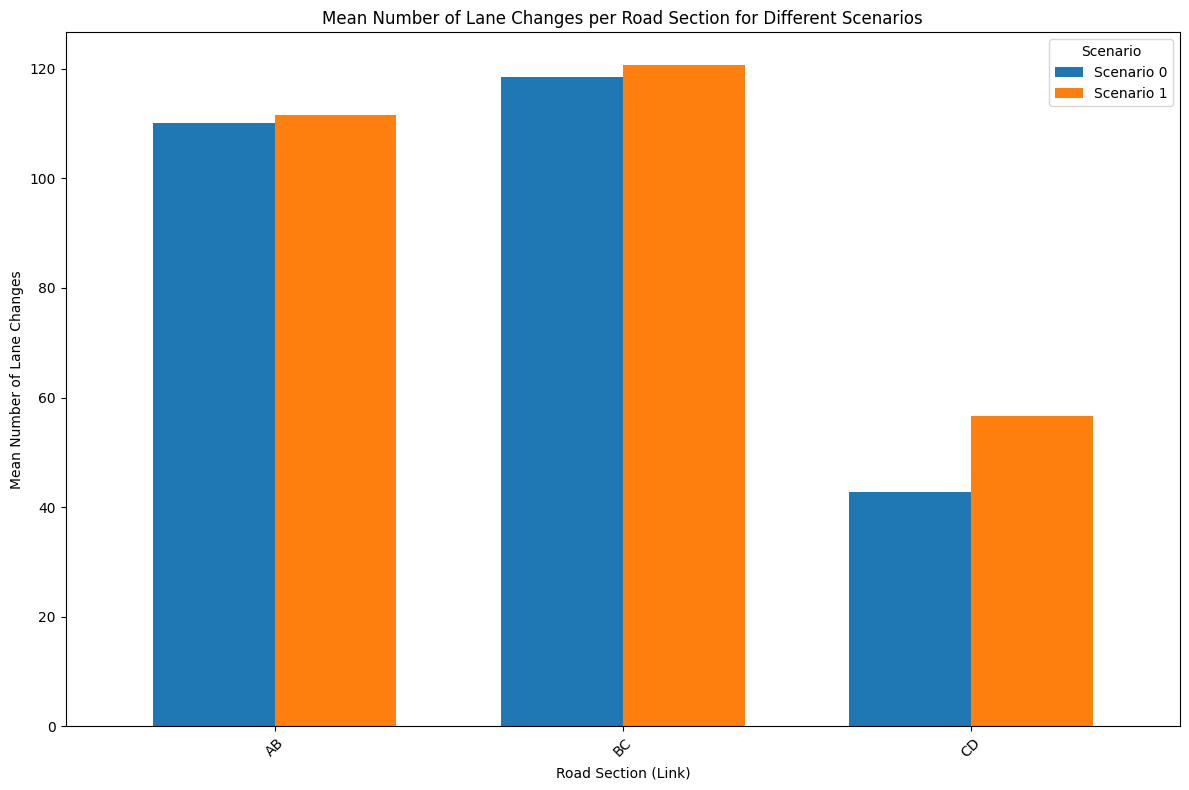

In [34]:
show_lane_changes_per_section([df_lc_data_0, df_lc_data_1], ['Scenario 0', 'Scenario 1'])

In [41]:
# merge all scenarios to analyse lane changing behaviour for each vehicle type without calling separate functions
df_lc_data = pd.concat([df_lc_data_0, df_lc_data_1])
df_gtu_lc = pd.concat([df_gtu_lc_0, df_gtu_lc_1])

In [42]:
# create dataframe for indicator turned on
def first_indicator_on(df):
    # sort by seed, run, gtu_id and time for sequence continuity
    df_indicator_on = df.sort_values(['seed', 'run', 'gtu_id', 'time']).reset_index(drop=True)

    # detect the start of each "indicator on" sequence
    df_indicator_on['indicator_on_start'] = (
        (df_indicator_on['turn_indicator'] != 'NONE') &
        (df_indicator_on['turn_indicator'].shift(1) == 'NONE') &
        (df_indicator_on['gtu_id'] == df_indicator_on['gtu_id'].shift(1)) &
        (df_indicator_on['seed'] == df_indicator_on['seed'].shift(1)) &
        (df_indicator_on['run'] == df_indicator_on['run'].shift(1))
    )
    
    # filter on 'indicator_on_start' is true
    first_indicator_on_times = df_indicator_on[df_indicator_on['indicator_on_start']]
    
    # drop temporary column and reset index
    first_indicator_on_times = first_indicator_on_times.drop(columns='indicator_on_start').reset_index(drop=True)
    
    return first_indicator_on_times

In [43]:
df_lc_indicator_on = first_indicator_on(df_gtu_lc)

In [44]:
# identify lane changing phases
def lane_change_periods(indicator_starts, lane_changes):
    # List to store lane change period information
    lane_change_periods = []
    
    # Dictionary to count broken-off lane changes by vehicle type
    broken_off_counts = defaultdict(int)
    
    # Loop through each unique (seed, run, gtu_id) combination
    for (seed, run, gtu_id), group in indicator_starts.groupby(['seed', 'run', 'gtu_id']):
        # Sort indicator starts by time for each GTU in a particular run and seed
        group = group.sort_values('time')
        
        # Get lane change events for the same (seed, run, gtu_id) combination
        lane_change_events = lane_changes[
            (lane_changes['seed'] == seed) &
            (lane_changes['run'] == run) &
            (lane_changes['gtu_id'] == gtu_id)
        ].sort_values('time')
        
        # Initialize pointer for lane change events
        lane_change_idx = 0

        # Retrieve gtu_type for this GTU
        gtu_type = group['gtu_type'].iloc[0]

        # Loop over each "indicator on" start event
        for _, start_row in group.iterrows():
            start_time = start_row['time']
            end_time = None
            lane_change_completed = False  # Flag to track if the lane change was completed
            
            # Find the next lane change event that occurs after the indicator start
            while lane_change_idx < len(lane_change_events):
                end_row = lane_change_events.iloc[lane_change_idx]
                end_time = end_row['time']
                
                # Check if this lane change event happens after the indicator start
                if end_time > start_time:
                    # Check if there is another "indicator on" event before this lane change event
                    next_indicator_on = group[group['time'] > start_time].iloc[1:]  # Remaining indicators after start_time
                    if not next_indicator_on.empty and next_indicator_on['time'].iloc[0] < end_time:
                        # Another "indicator on" event occurs before the lane change, break this pairing
                        break
                    
                    # Calculate the lane change duration since we found a valid pair
                    duration = end_time - start_time
                    lane_change_periods.append({
                        'seed': seed,
                        'run': run,
                        'gtu_id': gtu_id,
                        'gtu_type': gtu_type,
                        'start_time': start_time,
                        'end_time': end_time,
                        'lane_change_duration': duration
                    })
                    
                    # Mark the lane change as completed
                    lane_change_completed = True
                    lane_change_idx += 1  # Move to the next lane change event
                    break

                lane_change_idx += 1  # Move to the next lane change if not matched

            # If no lane change was completed, count it as a broken-off attempt for this gtu_type
            if not lane_change_completed:
                broken_off_counts[gtu_type] += 1

    # Convert results to DataFrame
    lane_change_periods_df = pd.DataFrame(lane_change_periods)
    
    # Convert broken-off counts to a DataFrame for easier analysis
    broken_off_counts_df = pd.DataFrame(list(broken_off_counts.items()), columns=['gtu_type', 'broken_off_count'])
    
    return lane_change_periods_df, broken_off_counts_df

In [45]:
# get the lane change periods from indicating till finished (start and end time)
df_lc_periods, df_lc_broken_off = lane_change_periods(df_lc_indicator_on, df_lc_data)

In [69]:
df_lc_periods.head()

,seed,run,gtu_id,gtu_type,start_time,end_time,lane_change_duration
0,0,0,239,LEVEL0,209.0,214.0,5.0
1,0,0,246,LEVEL0,212.5,217.5,5.0
2,0,0,273,LEVEL0,233.0,239.5,6.5
3,0,0,280,LEVEL0,231.5,234.0,2.5
4,0,0,281,LEVEL0,232.0,234.5,2.5


In [47]:
# times that vehicles turn on the indicator, but do not make the lane change manoeuvre
df_lc_broken_off.head()

,gtu_type,broken_off_count
0,LEVEL0,7054
1,LEVEL1,5915


In [48]:
def calculate_headway_phases(df_gtu_data, df_lane_change_periods, step_interval=0.5, standard_lane_change_duration=2.0):
    # Initialize dictionaries
    headway_data = {'indicating': [], 'start': [], 'maneuver': [], 'end': []}
    gtu_types = []

    # keep track of durations
    lane_change_durations = []

    # Loop through each lane change period entry
    for _, row in df_lane_change_periods.iterrows():
        seed, run, gtu_id, gtu_type, start_time, end_time = (
            row['seed'], row['run'], row['gtu_id'], row['gtu_type'], row['start_time'], row['end_time']
        )
        
        # Filter gtu_data for the current lane change period
        gtu_lane_change_data = df_gtu_data[
            (df_gtu_data['seed'] == seed) & 
            (df_gtu_data['run'] == run) &
            (df_gtu_data['gtu_id'] == gtu_id) &
            (df_gtu_data['time'] >= start_time) & 
            (df_gtu_data['time'] <= end_time)
        ].sort_values('time')

        # Identify the indicating phase
        indicating_data = gtu_lane_change_data[gtu_lane_change_data['turn_indicator'].isin(['LEFT', 'RIGHT'])]
        
        # Find when turn_indicator switches to 'NONE'
        start_maneuver_data = gtu_lane_change_data[(gtu_lane_change_data['turn_indicator'] == 'NONE')]
        maneuver_start_time = start_maneuver_data['time'].iloc[0] if not start_maneuver_data.empty else None

        # Calculate headway for each phase
        indicating_headway_distance = indicating_data['headway_distance'].replace([np.inf, -np.inf], np.nan).dropna().mean()
        indicating_headway_time = indicating_data['headway_time'].replace([np.inf, -np.inf], np.nan).dropna().mean()
        follower_indicating_headway_distance = indicating_data['follower_headway_distance'].replace([np.inf, -np.inf], np.nan).dropna().mean()
        follower_indicating_headway_time = indicating_data['follower_headway_time'].replace([np.inf, -np.inf], np.nan).dropna().mean()
        
        # Headway at the start of maneuver phase
        if maneuver_start_time:
            start_data = gtu_lane_change_data[gtu_lane_change_data['time'] == maneuver_start_time]
            start_headway_distance = start_data['headway_distance'].replace([np.inf, -np.inf], np.nan).mean()
            start_headway_time = start_data['headway_time'].replace([np.inf, -np.inf], np.nan).mean()
            follower_start_headway_distance = start_data['follower_headway_distance'].replace([np.inf, -np.inf], np.nan).mean()
            follower_start_headway_time = start_data['follower_headway_time'].replace([np.inf, -np.inf], np.nan).mean()
        else:
            start_headway_distance = start_headway_time = follower_start_headway_distance = follower_start_headway_time = None

        # Headway during maneuver phase
        if maneuver_start_time:
            maneuver_data = gtu_lane_change_data[
                (gtu_lane_change_data['time'] >= maneuver_start_time) & 
                (gtu_lane_change_data['time'] < end_time)
            ]
            maneuver_headway_distance = maneuver_data['headway_distance'].replace([np.inf, -np.inf], np.nan).dropna().mean()
            maneuver_headway_time = maneuver_data['headway_time'].replace([np.inf, -np.inf], np.nan).dropna().mean()
            follower_maneuver_headway_distance = maneuver_data['follower_headway_distance'].replace([np.inf, -np.inf], np.nan).dropna().mean()
            follower_maneuver_headway_time = maneuver_data['follower_headway_time'].replace([np.inf, -np.inf], np.nan).dropna().mean()
        else:
            maneuver_headway_distance = maneuver_headway_time = follower_maneuver_headway_distance = follower_maneuver_headway_time = None

        # Headway at the end of maneuver phase
        end_data = gtu_lane_change_data[gtu_lane_change_data['time'] == end_time]
        end_headway_distance = end_data['headway_distance'].replace([np.inf, -np.inf], np.nan).mean()
        end_headway_time = end_data['headway_time'].replace([np.inf, -np.inf], np.nan).mean()
        follower_end_headway_distance = end_data['follower_headway_distance'].replace([np.inf, -np.inf], np.nan).mean()
        follower_end_headway_time = end_data['follower_headway_time'].replace([np.inf, -np.inf], np.nan).mean()

        # Append to headway data lists
        headway_data['indicating'].append({
            'gtu_type': gtu_type, 'headway_distance': indicating_headway_distance, 'headway_time': indicating_headway_time,
            'follower_headway_distance': follower_indicating_headway_distance, 'follower_headway_time': follower_indicating_headway_time
        })
    
        headway_data['start'].append({
            'gtu_type': gtu_type, 'headway_distance': start_headway_distance, 'headway_time': start_headway_time,
            'follower_headway_distance': follower_start_headway_distance, 'follower_headway_time': follower_start_headway_time
        })
    
        headway_data['maneuver'].append({
            'gtu_type': gtu_type, 'headway_distance': maneuver_headway_distance, 'headway_time': maneuver_headway_time,
            'follower_headway_distance': follower_maneuver_headway_distance, 'follower_headway_time': follower_maneuver_headway_time
        })
    
        headway_data['end'].append({
            'gtu_type': gtu_type, 'headway_distance': end_headway_distance, 'headway_time': end_headway_time,
            'follower_headway_distance': follower_end_headway_distance, 'follower_headway_time': follower_end_headway_time
        })
        
        # Track gtu types
        if gtu_type not in gtu_types:
            gtu_types.append(gtu_type)

        # calculate lane change duration
        indicating_duration = maneuver_start_time - start_time if maneuver_start_time and start_time else None
        maneuver_duration = end_time - maneuver_start_time if end_time and maneuver_start_time else None
        lane_change_durations.append({
            'gtu_id': gtu_id,
            'gtu_type': gtu_type,
            'seed': seed,
            'run': run,
            'indicating_start_time': start_time,
            'maneuver_start_time': maneuver_start_time,
            'end_time': end_time,
            'maneuver_duration': maneuver_duration,
            'indicating_duration': indicating_duration
        })

    return headway_data, gtu_types, lane_change_durations

In [70]:
# retrieve the headway values for lane change manoeuvre phases (indicating, start, manouevre, end)
headway_data, gtu_types, lc_phase_durations = calculate_headway_phases(df_gtu_lc, df_lc_periods)

In [71]:
for phase_list in headway_data.values():  # Iterate over each phase's list
    if isinstance(phase_list, list):      # Ensure it's a list
        for entry in phase_list:          # Iterate over each entry in the list
            if entry.get('gtu_type') == 'LEVEL1':
                print("Found LEVEL1 entry:", entry)
                break

Found LEVEL1 entry: {'gtu_type': 'LEVEL1', 'headway_distance': 18.17800225454257, 'headway_time': 1.7983325734429385, 'follower_headway_distance': 19.16231993963459, 'follower_headway_time': 1.7513830634300454}
Found LEVEL1 entry: {'gtu_type': 'LEVEL1', 'headway_distance': 17.34688159670285, 'headway_time': 1.686937980762668, 'follower_headway_distance': 19.219568771499134, 'follower_headway_time': 1.928465448381681}
Found LEVEL1 entry: {'gtu_type': 'LEVEL1', 'headway_distance': 16.824885536753705, 'headway_time': 1.6259455586631164, 'follower_headway_distance': 18.58504712286377, 'follower_headway_time': 1.8383287346959811}
Found LEVEL1 entry: {'gtu_type': 'LEVEL1', 'headway_distance': nan, 'headway_time': nan, 'follower_headway_distance': nan, 'follower_headway_time': nan}


In [72]:
print(headway_data['start'][0])
print(headway_data['end'][0])

{'gtu_type': 'LEVEL0', 'headway_distance': nan, 'headway_time': nan, 'follower_headway_distance': 92.57110476292227, 'follower_headway_time': 3.433007576038353}
{'gtu_type': 'LEVEL0', 'headway_distance': 14.949987786346334, 'headway_time': 0.7186522711301134, 'follower_headway_distance': 19.55401222858653, 'follower_headway_time': 0.9457528431948644}


In [73]:
print(lc_phase_durations[800])

{'gtu_id': 1321, 'gtu_type': 'LEVEL0', 'seed': 0, 'run': 2, 'indicating_start_time': 1325.5, 'maneuver_start_time': 1326.0, 'end_time': 1328.0, 'maneuver_duration': 2.0, 'indicating_duration': 0.5}


In [74]:
df_lane_change_durations = pd.DataFrame(lc_phase_durations)
print(f'{len(df_lane_change_durations[df_lane_change_durations["maneuver_duration"] == 2.0]) / len(df_lane_change_durations) * 100}%')

76.86800894854586%


In [75]:
def plot_headway_phases_distance_and_time(headway_data, gtu_types):
    # Create dictionaries to store mean headways by type and phase
    mean_headways_distance = {gtu_type: {'start': None, 'maneuver': None, 'end': None} for gtu_type in gtu_types}
    mean_headways_time = {gtu_type: {'start': None, 'maneuver': None, 'end': None} for gtu_type in gtu_types}

    # Calculate mean headway distance for each phase by vehicle type
    for phase in ['start', 'maneuver', 'end']:
        for gtu_type in gtu_types:
            # For headway distance
            phase_distance_data = [
                entry['headway_distance'] 
                for entry in headway_data[phase] 
                if entry['gtu_type'] == gtu_type and isinstance(entry['headway_distance'], (int, float)) and not np.isnan(entry['headway_distance'])
            ]
            mean_distance = np.mean(phase_distance_data) if phase_distance_data else 0
            mean_headways_distance[gtu_type][phase] = mean_distance

            # For headway time
            phase_time_data = [
                entry['headway_time'] 
                for entry in headway_data[phase] 
                if entry['gtu_type'] == gtu_type and isinstance(entry['headway_time'], (int, float)) and not np.isnan(entry['headway_time'])
            ]
            mean_time = np.mean(phase_time_data) if phase_time_data else 0
            mean_headways_time[gtu_type][phase] = mean_time

    # Create the figure with two subplots side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Define x-tick labels and positions
    x_ticks = ['Start phase', 'Maneuver phase', 'End phase']
    x_positions = range(len(x_ticks))

    # Plot mean headway distance for each vehicle type on the left plot
    for gtu_type in gtu_types:
        headways_distance = [
            mean_headways_distance[gtu_type]['start'],
            mean_headways_distance[gtu_type]['maneuver'],
            mean_headways_distance[gtu_type]['end']
        ]
        axes[0].plot(x_positions, headways_distance, marker='o', label=gtu_type)

    # Customize the left plot (headway distance)
    axes[0].set_xticks(x_positions)
    axes[0].set_xticklabels(x_ticks)
    axes[0].set_xlabel('Lane change phase')
    axes[0].set_ylabel('Mean headway distance (m)')
    axes[0].set_title('Mean headway distance throughout lane change phases by vehicle type')
    axes[0].legend(title='Vehicle Type')
    axes[0].grid(True)

    # Plot mean headway time for each vehicle type on the right plot
    for gtu_type in gtu_types:
        headways_time = [
            mean_headways_time[gtu_type]['start'],
            mean_headways_time[gtu_type]['maneuver'],
            mean_headways_time[gtu_type]['end']
        ]
        axes[1].plot(x_positions, headways_time, marker='o', label=gtu_type)

    # Customize the right plot (headway time)
    axes[1].set_xticks(x_positions)
    axes[1].set_xticklabels(x_ticks)
    axes[1].set_xlabel('Lane change phase')
    axes[1].set_ylabel('Mean headway time (s)')
    axes[1].set_title('Mean headway time throughout lane change phases by vehicle type')
    axes[1].legend(title='Vehicle type')
    axes[1].grid(True)

    # Show the combined plot
    plt.tight_layout()
    plt.show()

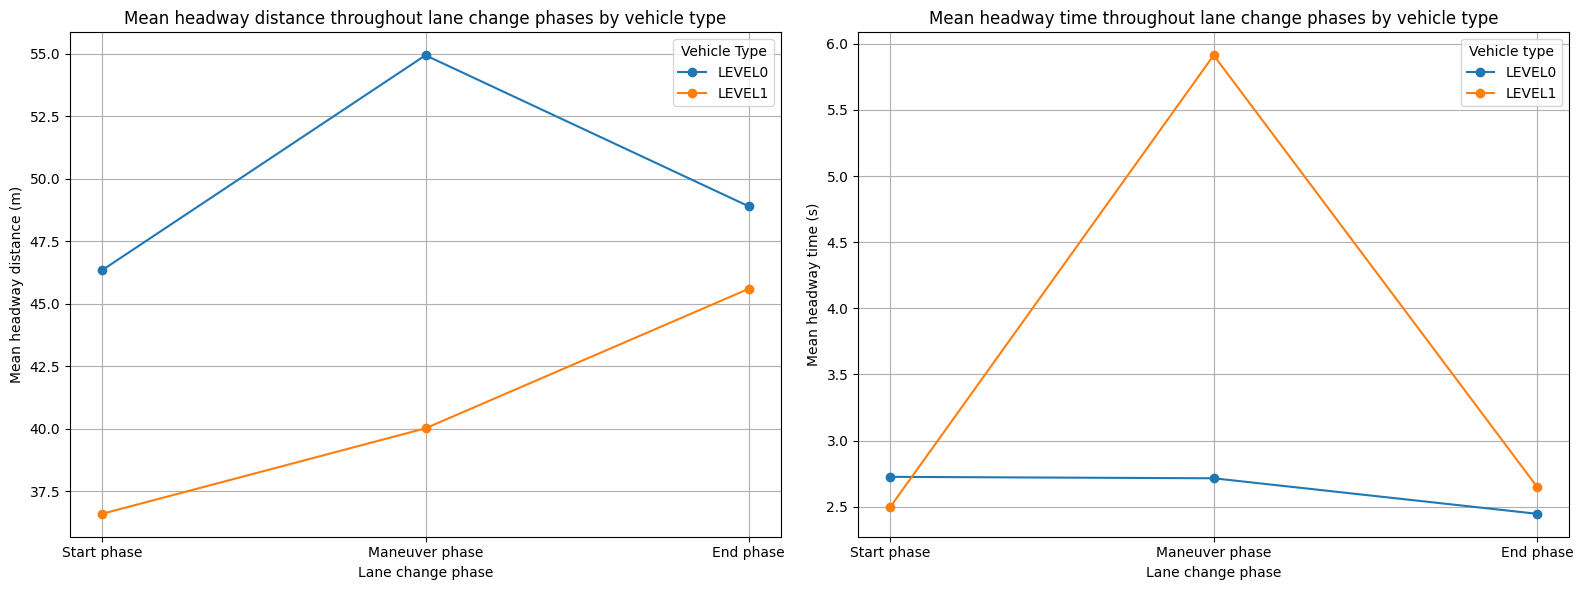

In [76]:
plot_headway_phases_distance_and_time(headway_data, gtu_types)

In [77]:
def plot_follower_phases_distance_and_time(headway_data, gtu_types):
    # Create dictionaries to store mean headways by type and phase
    mean_headways_distance = {gtu_type: {'start': None, 'maneuver': None, 'end': None} for gtu_type in gtu_types}
    mean_headways_time = {gtu_type: {'start': None, 'maneuver': None, 'end': None} for gtu_type in gtu_types}

    # Calculate mean headway distance for each phase by vehicle type
    for phase in ['start', 'maneuver', 'end']:
        for gtu_type in gtu_types:
            # For headway distance
            phase_distance_data = [
                entry['follower_headway_distance'] 
                for entry in headway_data[phase] 
                if entry['gtu_type'] == gtu_type and isinstance(entry['follower_headway_distance'], (int, float)) and not np.isnan(entry['follower_headway_distance'])
            ]
            mean_distance = np.mean(phase_distance_data) if phase_distance_data else 0
            mean_headways_distance[gtu_type][phase] = mean_distance

            # For headway time
            phase_time_data = [
                entry['follower_headway_time'] 
                for entry in headway_data[phase] 
                if entry['gtu_type'] == gtu_type and isinstance(entry['follower_headway_time'], (int, float)) and not np.isnan(entry['follower_headway_time'])
            ]
            mean_time = np.mean(phase_time_data) if phase_time_data else 0
            mean_headways_time[gtu_type][phase] = mean_time

    # Create the figure with two subplots side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Define x-tick labels and positions
    x_ticks = ['Start phase', 'Maneuver phase', 'End phase']
    x_positions = range(len(x_ticks))

    # Plot mean headway distance for each vehicle type on the left plot
    for gtu_type in gtu_types:
        headways_distance = [
            mean_headways_distance[gtu_type]['start'],
            mean_headways_distance[gtu_type]['maneuver'],
            mean_headways_distance[gtu_type]['end']
        ]
        axes[0].plot(x_positions, headways_distance, marker='o', label=gtu_type)

    # Customize the left plot (headway distance)
    axes[0].set_xticks(x_positions)
    axes[0].set_xticklabels(x_ticks)
    axes[0].set_xlabel('Lane change phase')
    axes[0].set_ylabel('Mean headway distance (m)')
    axes[0].set_title('Mean headway distance throughout lane change phases by vehicle type')
    axes[0].legend(title='Vehicle Type')
    axes[0].grid(True)

    # Plot mean headway time for each vehicle type on the right plot
    for gtu_type in gtu_types:
        headways_time = [
            mean_headways_time[gtu_type]['start'],
            mean_headways_time[gtu_type]['maneuver'],
            mean_headways_time[gtu_type]['end']
        ]
        axes[1].plot(x_positions, headways_time, marker='o', label=gtu_type)

    # Customize the right plot (headway time)
    axes[1].set_xticks(x_positions)
    axes[1].set_xticklabels(x_ticks)
    axes[1].set_xlabel('Lane change phase')
    axes[1].set_ylabel('Mean headway time (s)')
    axes[1].set_title('Mean headway time throughout lane change phases by vehicle type')
    axes[1].legend(title='Vehicle type')
    axes[1].grid(True)

    # Show the combined plot
    plt.tight_layout()
    plt.show()

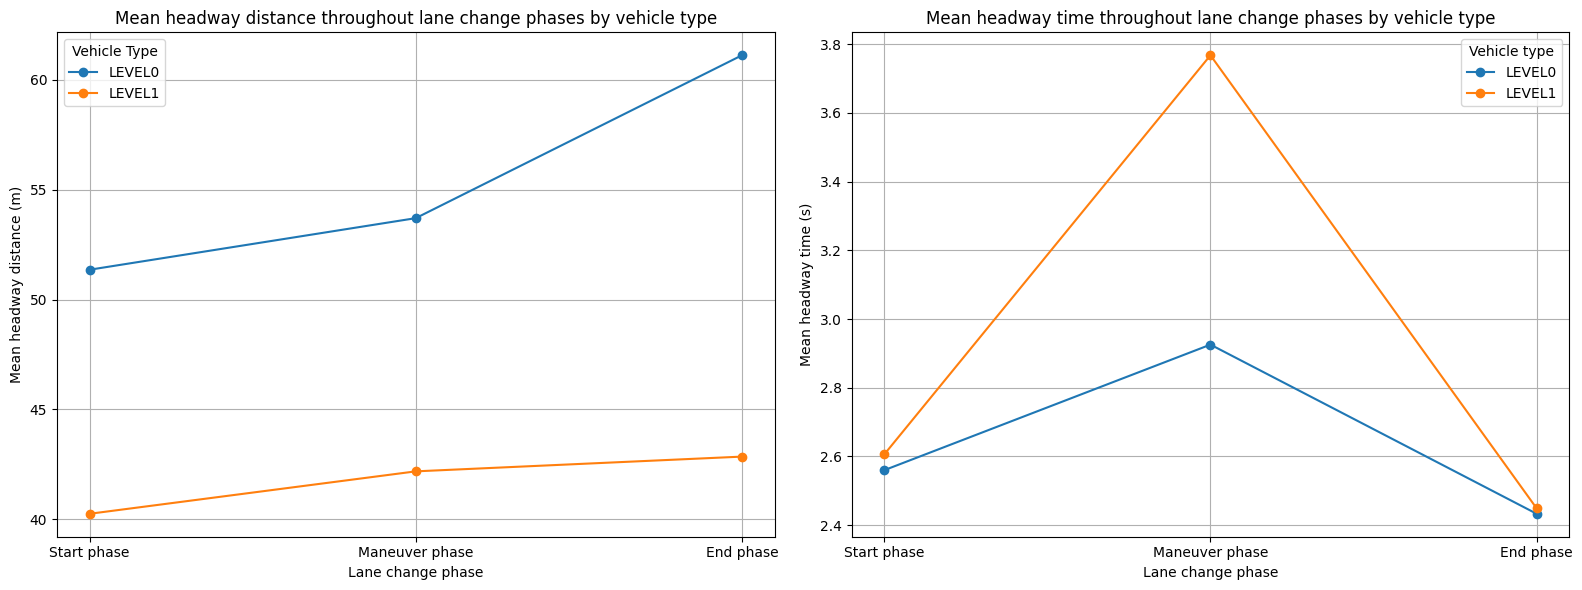

In [78]:
plot_follower_phases_distance_and_time(headway_data, gtu_types)